# Advanced Lane Line Detection

TODO: short description of project here

In [1]:
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import numpy as np

%matplotlib inline

------

In [2]:
def calibrate_camera(imgs, nx=9, ny=6):
    # Collect object points and image points for use in calibrating camera
    obj_pts = [] # 3D points in the real world space
    img_pts = [] # 2D points in the image plane

    # Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ... , (8,5,0)
    obj_pt = np.zeros((ny * nx, 3), np.float32)
    # z-coordinate will stay zero; but x, y coordinates need to be generated
    obj_pt[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    for fname in imgs:
        img = mpimg.imread(fname)

        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        found, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If corners are found, add object points and image points
        if found:
            #print('found corners in {}'.format(fname))
            img_pts.append(corners)
            obj_pts.append(obj_pt)

            img = cv2.drawChessboardCorners(img, (nx,ny), corners, found)
            plt.imshow(img)
            
    return obj_pts, img_pts
        
        

In [3]:
def correct_distortion(image, object_points, image_points):
    '''
    Calibrates camera and corrects for camera distortions in the provided image
    based on the provided object points mapped to the provided image points.
    Returns the corrected, undistorted image.
    '''
    ret, cam_mtx, dist_coeffs, rot_vecs, trans_vecs = \
        cv2.calibrateCamera(object_points, image_points, image.shape[1::-1], None, None)
        
    return cv2.undistort(image, cam_mtx, dist_coeffs, None, None)

In [4]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    '''Calculate the directional gradient and apply the threshold'''
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobel = cv2.Sobel(gray, cv2.CV_64F, orient=='x', orient=='y', ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled = np.uint8((255 * abs_sobel) / np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled)
    grad_binary[(scaled >= thresh[0]) & (scaled <= thresh[1])] = 1
    return grad_binary


In [5]:
def mag_thresh(image, sobel_kernel=3, thresh=(0, 255)):
    '''Calculate the gradient magnitude and apply the threshold'''
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    mag_sobelxy = np.sqrt(np.square(sobelx) + np.square(sobely))
    scaled = np.uint8((255 * mag_sobelxy) / np.max(mag_sobelxy))
    mag_binary = np.zeros_like(scaled)
    mag_binary[(scaled >= thresh[0]) & (scaled <= thresh[1])] = 1
    return mag_binary


In [6]:
def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    '''Calculate gradient direction and apply the threshold'''
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    mag_sobelx = np.sqrt(np.square(sobelx))
    mag_sobely = np.sqrt(np.square(sobely))
    grad_dir = np.arctan2(mag_sobely, mag_sobelx)
    #scaled = np.uint8((255 * grad_dir) / np.max(grad_dir))
    dir_binary = np.zeros_like(grad_dir)
    dir_binary[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    return dir_binary


In [7]:
def hls_threshold(image, channel='h', thresh=(90, 255)):
    '''Calculate the color threshold for the requested channel
    and apply the threshold
    
    arguments:
    image -- a color image in RGB format
    channel -- the requested channel to use for applying the threshold values
    thresh -- min and max (inclusive) values for the range of the threshold to apply
    '''
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    
    layer = H
    if channel == 'l' or channel == 'L':
        layer = L
    elif channel == 's' or channel == 'S':
        layer = S
        
    hls_binary = np.zeros_like(layer)
    hls_binary[(layer > thresh[0]) & (layer <= thresh[1])] = 1
    return hls_binary


In [8]:
def combine_thresholds(image, sobel_kernel_size=5, 
                       grad_x_thresh=(20, 100),
                       grad_y_thresh=(20, 100),
                       magnitude_thresh=(50, 75),
                       grad_dir_thresh=(0.65, 1.35),
                       s_chan_thresh=(200, 255),
                       h_chan_thresh=(70, 150),
                       l_chan_thresh=(150, 255)):
    '''
    Combines gradient and color thresholds applied to the provided image
    to maximize identification of lane lines
    '''
    # TODO: tune default threshold ranges
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) # just for visual reference
    
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=sobel_kernel_size, thresh=grad_x_thresh)
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=sobel_kernel_size, thresh=grad_y_thresh)
    mag_binary = mag_thresh(image, sobel_kernel=sobel_kernel_size, thresh=magnitude_thresh)
    dir_binary = dir_threshold(image, sobel_kernel=sobel_kernel_size, thresh=grad_dir_thresh)
    s_chan_binary = hls_threshold(image, channel='s', thresh=s_chan_thresh)
    h_chan_binary = hls_threshold(image, channel='h', thresh=h_chan_thresh)
    l_chan_binary = hls_threshold(image, channel='l', thresh=l_chan_thresh)
    
    # Combine the applied thresholds 
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | \
             ((mag_binary == 1) & (dir_binary == 1)) | \
             (((s_chan_binary == 1) & (h_chan_binary == 0)) | (l_chan_binary == 1))] = 1
        
    return combined, gray, gradx, grady, mag_binary, dir_binary, s_chan_binary, h_chan_binary, l_chan_binary


In [9]:
def warp_img(image, src, dst):
    perspective_M = cv2.getPerspectiveTransform(src, dst)
    img_size = (image.shape[1], image.shape[0])
    warped = cv2.warpPerspective(image, perspective_M, img_size, flags=cv2.INTER_LINEAR)
    return warped, perspective_M


In [10]:
def display_images(images, titles, cmaps=[]):
    '''
    Displays two images side by side.
    
    arguments:
    images -- a list of two images to display. (anything in the list beyond the first two will be ignored)
    cmaps  -- a list of color maps for the destination image
    titles -- a list of titles to match the provided images
    '''
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.set_title(titles[0], fontsize=30)
    if cmaps and cmaps[0]:
        ax1.imshow(images[0], cmap=cmaps[0])
    else:
        ax1.imshow(images[0])
                          
    ax2.set_title(titles[1], fontsize=30)
    if cmaps and cmaps[1]:
        ax2.imshow(images[1], cmap=cmaps[1])
    else:
        ax2.imshow(images[1])
        
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [11]:
def draw_polygon(image, vertices, color= 'r'):
    '''Draw polygon formed by the provide vertices onto the provided image'''
    fig, ax = plt.subplots(1)
    area_of_interest = patches.Polygon(vertices, fill=False, edgecolor=color)
    ax.imshow(image, cmap='gray')
    ax.add_patch(area_of_interest)
    plt.show()
    

In [12]:
def get_histogram(image):
    '''Retrieve histogram of pixel density for lane lines in lower half of the image'''
    return np.sum(image[image.shape[0]//2:,:], axis=0)    
    

------




### 1. Camera calibration

In [13]:
imgs = glob.glob('./camera_cal/calibration*.jpg')
object_points, image_points = calibrate_camera(imgs)
print(len(object_points), len(image_points))

17 17


### 2. Distortion correction

In [46]:
#test_img = mpimg.imread('./test_images/straight_lines1.jpg')
test_img = mpimg.imread('./test_images/test2.jpg')
corrected = correct_distortion(test_img, object_points, image_points)
display_images([test_img, corrected], ['Original', 'Undistorted'])

### 3. Color/gradient thresholding

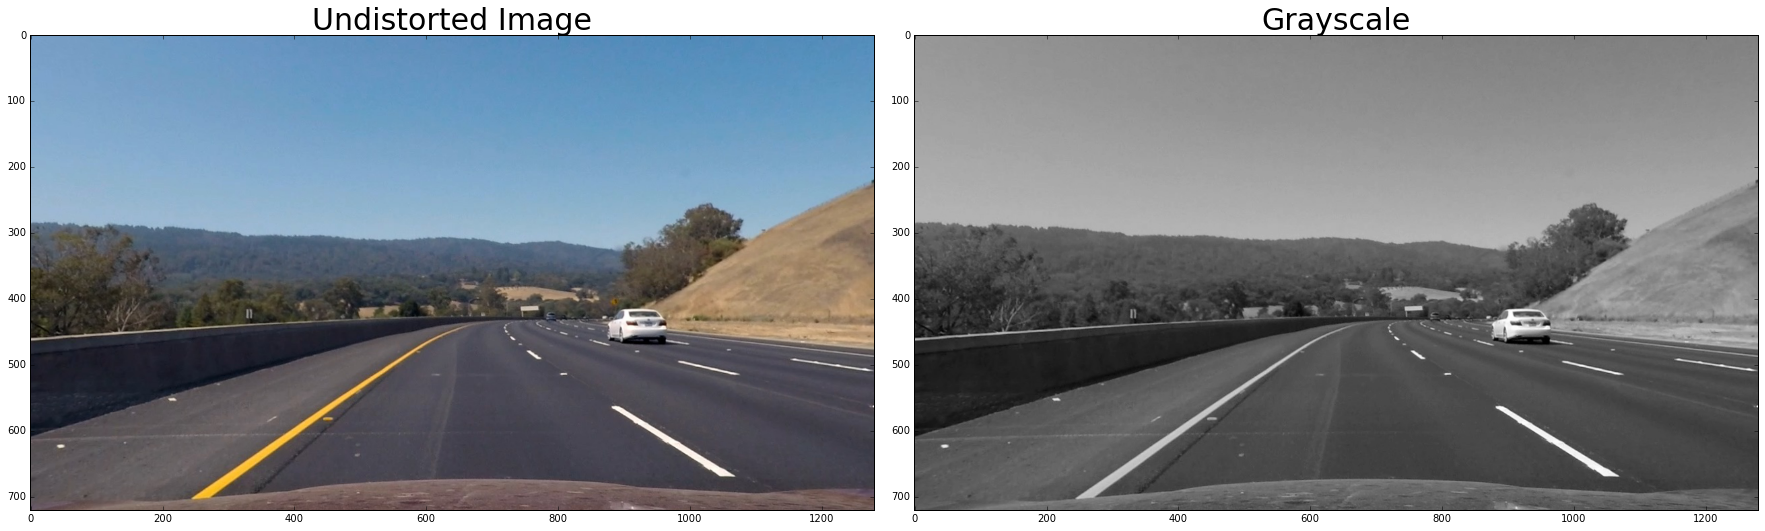

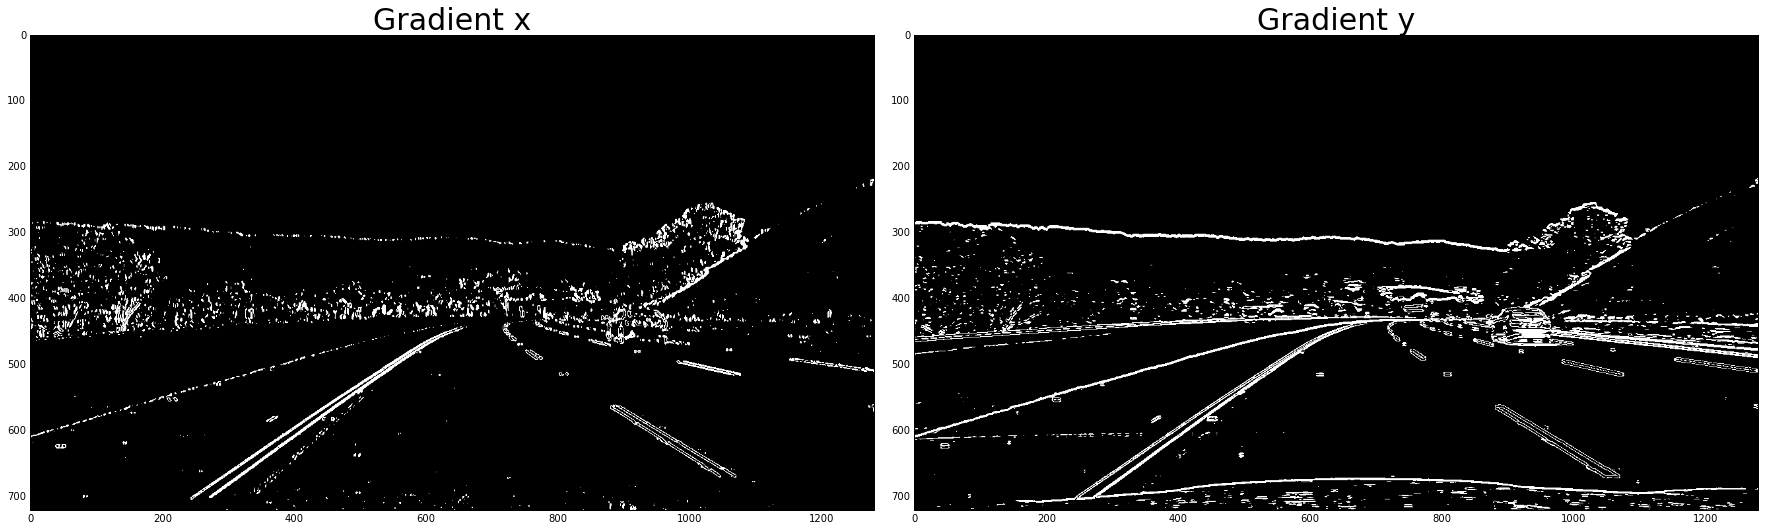

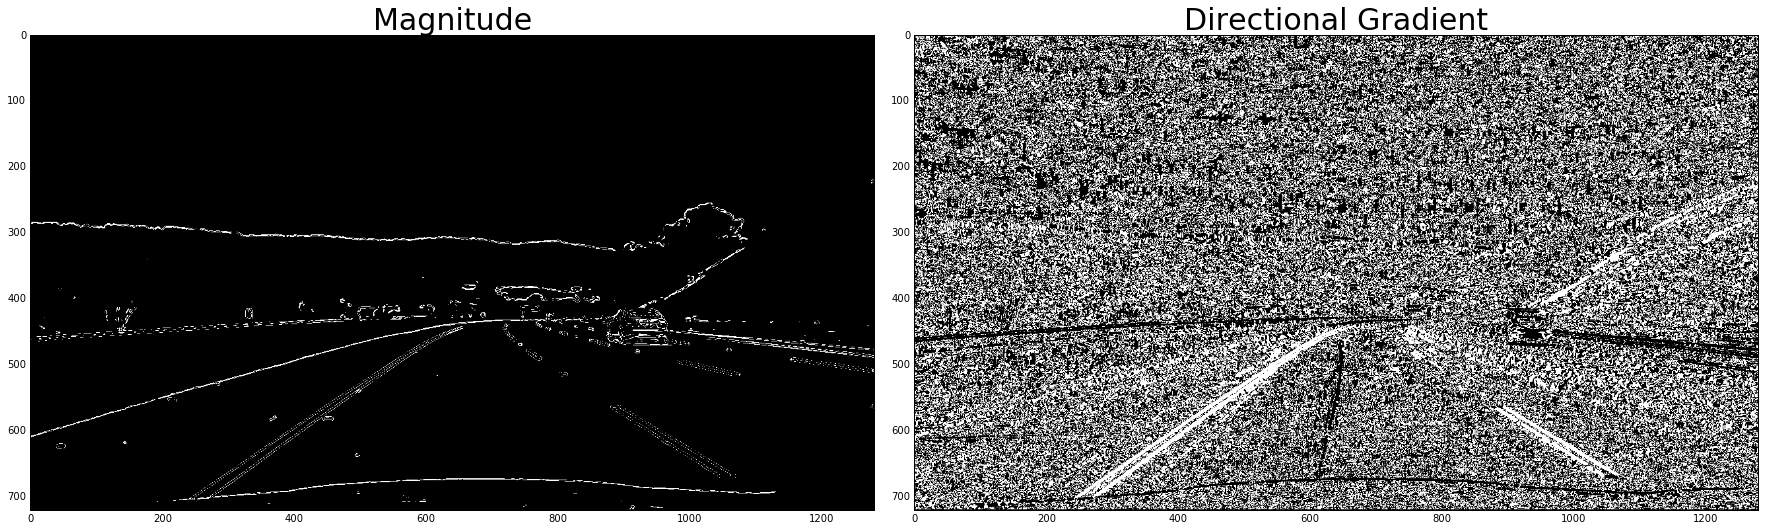

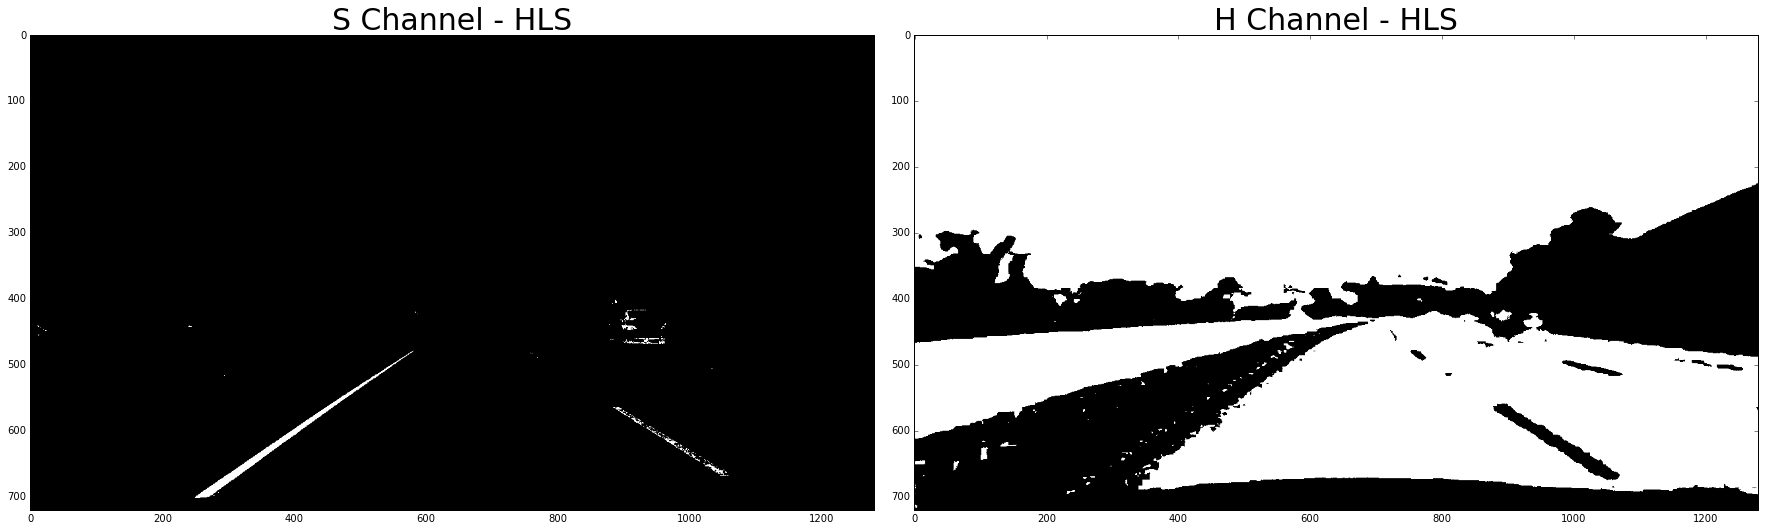

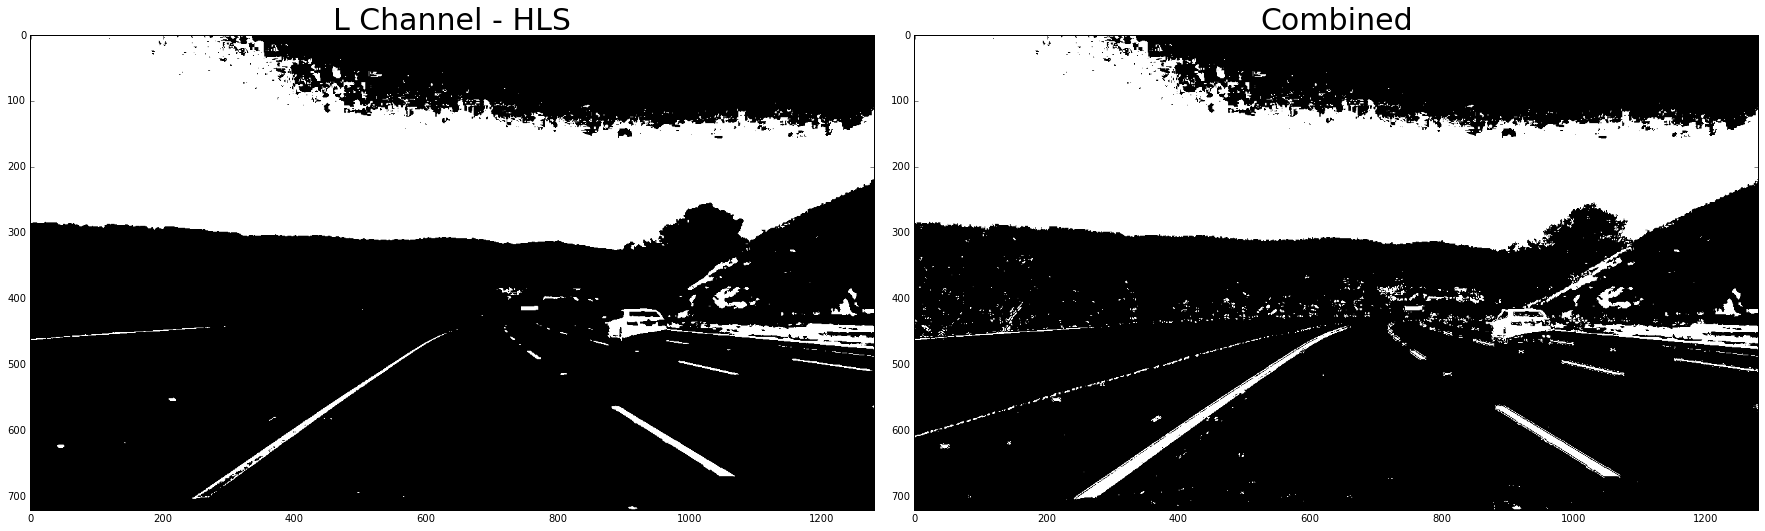

In [29]:
# Test combined threshold
combined_grad_color, gray, gradx, grady, mag_binary, \
dir_binary, s_chan_binary, h_chan_binary, l_chan_binary = \
    combine_thresholds(corrected)
    
display_images([corrected, gray], ['Undistorted Image', 'Grayscale'], ['', 'gray'])
display_images([gradx, grady], ['Gradient x', 'Gradient y'], ['gray', 'gray'])
display_images([mag_binary, dir_binary], ['Magnitude', 'Directional Gradient'], ['gray', 'gray'])
display_images([s_chan_binary, h_chan_binary], ['S Channel - HLS', 'H Channel - HLS'], ['gray', 'gray'])
display_images([l_chan_binary, combined_grad_color], ['L Channel - HLS', 'Combined'], ['gray', 'gray'])

### 4. Perspective transform

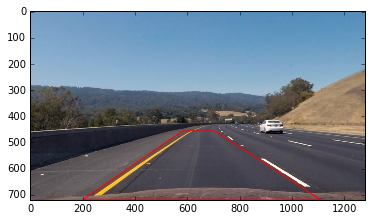

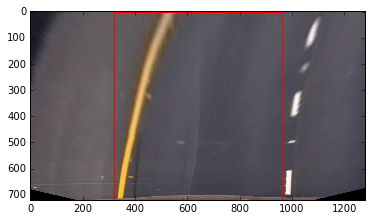

In [30]:
# Source image vertices for area of interest
stlx =  585
strx =  700
st_y =  455
sblx =  200
sbrx = 1110
sb_y =  720

src = np.float32([[strx, st_y],[sbrx, sb_y],
                  [sblx, sb_y],[stlx, st_y]])

# Destination image vertices for transformed area of interest
dtlx =  320
dtrx =  960
dt_y =    0
dblx = dtlx
dbrx = dtrx
db_y =  720

dst = np.float32([[dtrx, dt_y],[dbrx, db_y],
                  [dblx, db_y],[dtlx, dt_y]])

# Do perspective transformation to get a "Bird's eye view"
warped_test, p_M = warp_img(corrected, src, dst)
warped_combined, persp_M = warp_img(combined_grad_color, src, dst)

draw_polygon(corrected, src)
draw_polygon(warped_test, dst)

### 5. Detect lane lines

leftx_current: 386, rightx_current: 989
leftx_current: 351, rightx_current: 983
leftx_current: 358, rightx_current: 986
leftx_current: 377, rightx_current: 997
leftx_current: 394, rightx_current: 996
leftx_current: 416, rightx_current: 1012
leftx_current: 434, rightx_current: 1028
leftx_current: 456, rightx_current: 1048
leftx_current: 483, rightx_current: 1062


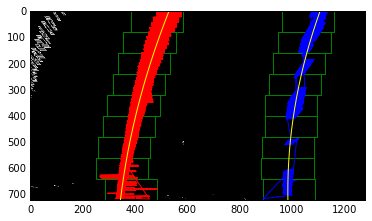

In [45]:

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = get_histogram(warped_combined)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((warped_combined, warped_combined, warped_combined)) * 255

# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(warped_combined.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = warped_combined.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
sliding_windows = []
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = warped_combined.shape[0] - (window+1)*window_height
    win_y_high = warped_combined.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    #color=[0,255,0], thickness=2) 
    #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    #color=[0,255,0], thickness=2)
    sliding_windows.append([(win_xleft_low,win_y_low),(win_xleft_high,win_y_high)])
    sliding_windows.append([(win_xright_low,win_y_low),(win_xright_high,win_y_high)])
    
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

### Visualize ###
# Generate x and y values for plotting
ploty = np.linspace(0, warped_combined.shape[0]-1, warped_combined.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

#Draw sliding windows
fig, ax = plt.subplots(1)
for win_corners in sliding_windows:
    l_x, b_y = win_corners[0]
    r_x, t_y = win_corners[1]
    vertices = [[l_x, b_y], [l_x, t_y], [r_x, t_y], [r_x, b_y]]
    #cv2.rectangle(out_img, win_corners[0], win_corners[1], [0,255,0], 2)
    win_box = patches.Polygon(vertices, fill=False, edgecolor='g')
    ax.imshow(out_img)
    ax.add_patch(win_box)

#Draw lane line pixels
ax.plot(leftx, lefty, color='red')
ax.plot(rightx, righty, color='blue')

ax.plot(left_fitx, ploty, color='yellow')
ax.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()



In [ ]:
plt.imshow(warped_combined)

### 6. Determine the lane curvature

------

In [ ]:
### Implement find lane pipeline ###

# 1. Calibrate camera
imgs = glob.glob('./camera_cal/calibration*.jpg')
object_points, image_points = calibrate_camera(imgs)

# 2. Correct image distortions
test_img = mpimg.imread('./test_images/straight_lines1.jpg')
#test_img = mpimg.imread('./test_images/test3.jpg')
corrected = correct_distortion(test_img, object_points, image_points)

# 3. Apply color and/or gradient thresholds
combined_grad_color, gray, gradx, grady, mag_binary, \
dir_binary, s_chan_binary, h_chan_binary, l_chan_binary = \
    combine_thresholds(corrected)

# 4. Apply perspective transform
# Source image vertices for area of interest
stlx =  585
strx =  700
st_y =  455
sblx =  200
sbrx = 1110
sb_y =  720

src = np.float32([[strx, st_y],[sbrx, sb_y],
                  [sblx, sb_y],[stlx, st_y]])

# Destination image vertices for transformed area of interest
dtlx =  320
dtrx =  960
dt_y =    0
dblx = dtlx
dbrx = dtrx
db_y =  720

dst = np.float32([[dtrx, dt_y],[dbrx, db_y],
                  [dblx, db_y],[dtlx, dt_y]])

# Do perspective transform to get a "Bird's eye view"
warped_test, p_M = warp_img(corrected, src, dst)
warped_combined, persp_M = warp_img(combined_grad_color, src, dst)

# 5. Detect lane lines
# 6. Determine lane curavature
# 7. Mark lane